# Advanced Use: Uncertainty Propagation
## 1. Introduction
Digital image correlation (DIC) delivers displacement/strain maps from paired images, yet the reliability of those maps hinges on how camera noise and illumination errors propagate through the entire pipeline. Applications such as failure analysis or data assimilation require quantified uncertainties rather than single deterministic strain fields.

This notebook extends *Simple2D_DIC.ipynb* by re-using the same dataset, solver, and visualization utilities while adding a rigorous uncertainty analysis. We rely on three key ideas:

1. **Uncertainty propagation matters:** knowing how perturbations on the deformed image $I_2$ alter the strain tensor $\varepsilon(u)$ helps decide where the measurement is trustworthy (e.g., textured areas) and where additional sensing or regularization is needed.
2. **Automatic differentiation is ideal:** the D2IC solver is already written with JAX primitives, which means we can differentiate the full map $I_2 \to u \to \varepsilon(u)$ without assembling huge Jacobian matrices.
3. **First-order linearization:** the propagated uncertainty is computed around a converged solution $(I_2, u_\star, \varepsilon(u_\star))$ using a JVP (Jacobian-vector product) so that small perturbations $\delta I_2$ yield $\delta \varepsilon \approx (\partial \varepsilon/\partial I_2)\, \delta I_2$.

The rest of the notebook follows the requested structure: compute the reference DIC solution, define a noise model, build a differentiable end-to-end map, propagate uncertainty with JVPs, and visualize the resulting spatially varying strain uncertainty.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for candidate in [start, *start.parents]:
        if (candidate / "doc" / "img" / "PlateHole").exists():
            return candidate
    raise FileNotFoundError("Could not locate the repository root (doc/img/PlateHole folder missing).")

repo_root = find_repo_root(Path.cwd())
coorjax_root = repo_root / "CoorJAx"
if str(coorjax_root) not in sys.path:
    sys.path.insert(0, str(coorjax_root))

import jax
import jax.numpy as jnp
from jax import lax
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

from CoorJAx.D2IC.dic import Dic
from D2IC.dic_plotter import DICPlotter
from D2IC import generate_roi_mesh
from D2IC.PixelQuad import (
    compute_pixel_state,
    jacobi_nodal_step_spring,
    compute_green_lagrange_strain_nodes_lsq,
)

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

repo_root

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PosixPath('/workspaces/08_dic')

## 2. Reference DIC Solution
We first reproduce the full DIC workflow used in *Simple2D_DIC.ipynb*: load the PlateHole images, generate the ROI mesh, estimate the initial displacement, run the global Gauss–Newton solver, apply a nodal refinement, and store the strain tensor $\varepsilon(u_\star)$ that serves as the linearization point.

im_ref: (1040, 400) float32
im_def: (1040, 400) float32
mask : (1040, 400, 4) uint8


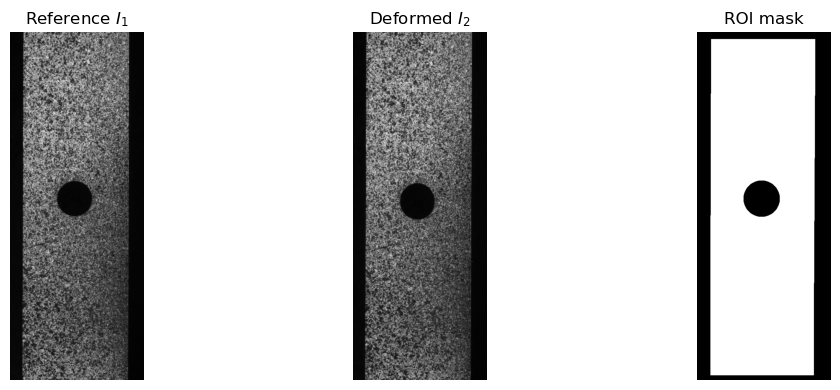

In [37]:
img_dir = repo_root / "doc" / "img" / "PlateHole"
out_dir = repo_root / "CoorJAx" / "doc" / "_outputs"
out_dir.mkdir(exist_ok=True)

im_ref = imread(img_dir / "ohtcfrp_00.tif").astype(np.float32)
im_def = imread(img_dir / "ohtcfrp_10.tif").astype(np.float32)
mask = imread(img_dir / "roi.tif")

print("im_ref:", im_ref.shape, im_ref.dtype)
print("im_def:", im_def.shape, im_def.dtype)
print("mask :", mask.shape, mask.dtype)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap="gray", origin="lower")
ax[0].set_title("Reference $I_1$")
ax[1].imshow(im_def, cmap="gray", origin="lower")
ax[1].set_title("Deformed $I_2$")
ax[2].imshow(mask, cmap="gray", origin="lower")
ax[2].set_title("ROI mask")
for a in ax:
    a.axis("off")
plt.tight_layout()
plt.show()

In [38]:
mask_path = img_dir / "roi.tif"
mesh_path = out_dir / "Advanced_Use_Uncertainty_roi_mesh_40px.msh"

mesh_path_generated = generate_roi_mesh(mask_path, element_size=12.0, msh_path=str(mesh_path))
if mesh_path_generated is None:
    raise RuntimeError("Mesh generation failed.")
mesh_path = Path(mesh_path_generated)
mesh_path

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Circle)
Info    : [ 70%] Meshing curve 6 (Circle)
Info    : [ 80%] Meshing curve 7 (Circle)
Info    : [ 90%] Meshing curve 8 (Circle)
Info    : Done meshing 1D (Wall 0.000389725s, CPU 0.000433s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Blossom: 7623 internal 252 closed
Info    : Blossom recombination completed (Wall 0.068298s, CPU 0.068406s): 2525 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.794731, min Q = 0.503638
Info    : Done meshing 2D (Wall 0.106824s, CPU 0.107472s)
Info    : 2655 nodes 2789 elements
Info    : Writing '/workspaces/08_dic/CoorJAx/doc/_outputs/Advanced_Use_Uncertainty_roi_mesh_40px.msh'...
Info    : Done writing '/workspaces/08_dic/CoorJAx/doc/_outputs/Advanced_Use_Uncertainty_roi

PosixPath('/workspaces/08_dic/CoorJAx/doc/_outputs/Advanced_Use_Uncertainty_roi_mesh_40px.msh')

In [39]:
dic = Dic(mesh_path=str(mesh_path))
dic.precompute_pixel_data(jnp.asarray(im_ref))
dic

Retained matches: 9


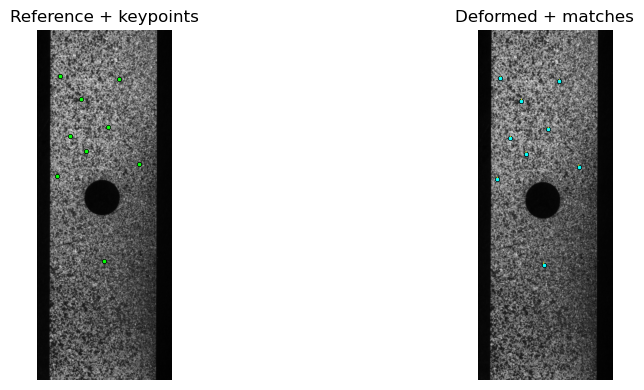

In [40]:
disp_guess, extras = dic.compute_feature_disp_guess_big_motion(
    im_ref,
    im_def,
    n_patches=32,
    patch_win=21,
    patch_search=15,
    refine=True,
    search_dilation=5.0,
)

pts_ref = extras["pts_ref"]
pts_def = extras["pts_def"]
print("Retained matches:", pts_ref.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap="gray", origin="lower")
ax[0].scatter(pts_ref[:, 0], pts_ref[:, 1], s=10, c="lime", edgecolors="k", linewidths=0.5)
ax[0].set_title("Reference + keypoints")

ax[1].imshow(im_def, cmap="gray", origin="lower")
ax[1].scatter(pts_def[:, 0], pts_def[:, 1], s=10, c="cyan", edgecolors="k", linewidths=0.5)
ax[1].quiver(
    pts_ref[:, 0],
    pts_ref[:, 1],
    pts_def[:, 0] - pts_ref[:, 0],
    pts_def[:, 1] - pts_ref[:, 1],
    angles="xy",
    scale_units="xy",
    scale=1.0,
    color="yellow",
    width=0.003,
)
ax[1].set_title("Deformed + matches")
for a in ax:
    a.axis("off")
plt.tight_layout()
plt.show()

[CG] iter   0  J=8.5573e+02  ||g||=4.704e+00
        alpha=1.000e+00, J_new=8.3570e+02
[CG] iter   1  J=8.3570e+02  ||g||=3.857e+00
        alpha=1.000e+00, J_new=8.2206e+02
[CG] iter   2  J=8.2206e+02  ||g||=3.254e+00
        alpha=1.000e+00, J_new=8.1227e+02
[CG] iter   3  J=8.1227e+02  ||g||=2.783e+00
        alpha=1.000e+00, J_new=8.0505e+02
[CG] iter   4  J=8.0505e+02  ||g||=2.424e+00
        alpha=1.000e+00, J_new=7.9950e+02
[CG] iter   5  J=7.9950e+02  ||g||=2.187e+00
        alpha=1.000e+00, J_new=7.9486e+02
[CG] iter   6  J=7.9486e+02  ||g||=2.095e+00
        alpha=1.000e+00, J_new=7.9063e+02
[CG] iter   7  J=7.9063e+02  ||g||=1.948e+00
        alpha=1.000e+00, J_new=7.8699e+02
[CG] iter   8  J=7.8699e+02  ||g||=1.807e+00
        alpha=1.000e+00, J_new=7.8384e+02
[CG] iter   9  J=7.8384e+02  ||g||=1.708e+00
        alpha=1.000e+00, J_new=7.8101e+02
[CG] iter  10  J=7.8101e+02  ||g||=1.619e+00
        alpha=1.000e+00, J_new=7.7844e+02
[CG] iter  11  J=7.7844e+02  ||g||=1.571e+0

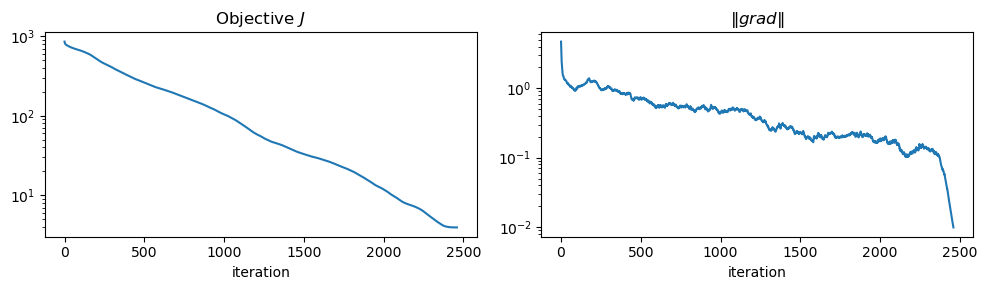

In [42]:
displacement, history = dic.run_dic(
    im_ref,
    im_def,
    disp_guess=disp_guess,
    max_iter=5000,
    tol=1e-2,
    reg_type="spring",
    alpha_reg=0.05,
)

hist = np.asarray(history)
print("Last solver state:", hist[-1])

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].semilogy(hist[:, 0])
ax[0].set_title("Objective $J$")
ax[0].set_xlabel("iteration")
ax[1].semilogy(hist[:, 1])
ax[1].set_title(r"$\|grad\|$")
ax[1].set_xlabel("iteration")
plt.tight_layout()
plt.show()

[Nodal-spring_jacobi] sweep 1/10, J=3.7220e+00
[Nodal-spring_jacobi] sweep 2/10, J=4.7223e+00
[Nodal-spring_jacobi] sweep 3/10, J=4.9088e+00
[Nodal-spring_jacobi] sweep 4/10, J=4.9829e+00
[Nodal-spring_jacobi] sweep 5/10, J=5.0084e+00
[Nodal-spring_jacobi] sweep 6/10, J=5.0215e+00
[Nodal-spring_jacobi] sweep 7/10, J=5.0287e+00
[Nodal-spring_jacobi] sweep 8/10, J=5.0332e+00
[Nodal-spring_jacobi] sweep 9/10, J=5.0360e+00
[Nodal-spring_jacobi] sweep 10/10, J=5.0380e+00


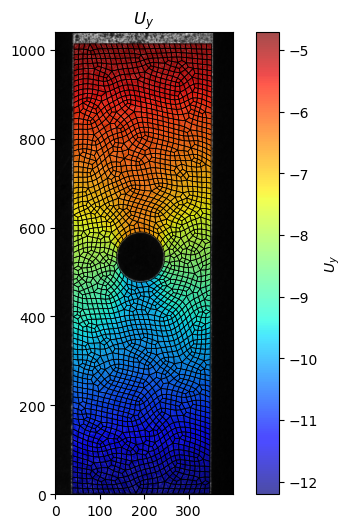

In [43]:
u_star = dic.run_dic_nodal(
    im_ref,
    im_def,
    disp_init=displacement,
    n_sweeps=10,
    lam=0.1,
    reg_type="spring_jacobi",
    alpha_reg=0.001,
    max_step=0.2,
    omega_local=0.5,
)

plotter_u = DICPlotter(
    background_image=im_def,
    displacement=np.asarray(u_star),
    dic_object=dic,
)
fig, _ = plotter_u.plot_displacement_component("Uy", image_alpha=0.7)
plt.show()

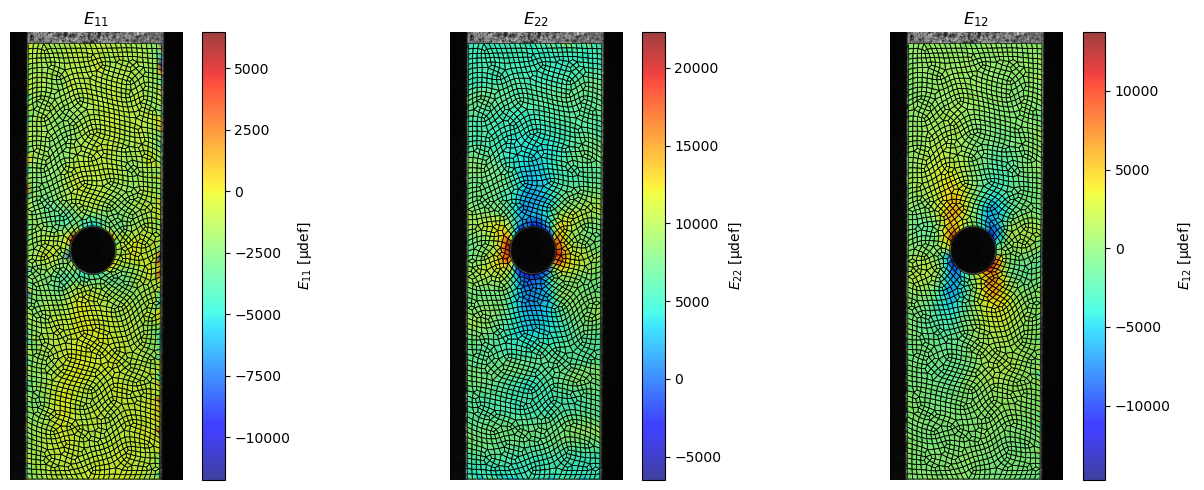

Stored linearization point: u_star shape (2651, 2)


In [44]:
F_star, E_star = dic.compute_green_lagrange_strain_nodes(
    u_star,
    k_ring=2,
    gauge_length=40.0,
)

plotter_ref = DICPlotter(
    background_image=im_def,
    displacement=np.asarray(u_star),
    strain_fields=(F_star, E_star),
    dic_object=dic,
)

component_names = ("Exx", "Eyy", "Exy")
strain_scale = 1e6
strain_unit_label = "µdef"


def to_micro(values):
    '''Convert strain values to micro-deformation.'''
    return strain_scale * values


def plot_scalar_field(ax, values, title, cmap="jet", alpha=0.75):
    ax.imshow(plotter_ref.background_image, cmap="gray", origin="lower", alpha=1.0)
    mesh = ax.tripcolor(
        plotter_ref.triangulation,
        values,
        shading="gouraud",
        cmap=cmap,
        alpha=alpha,
        edgecolors="none",
        linewidth=0.0,
    )
    quad_mesh = plotter_ref._quad_mesh_collection()
    if quad_mesh is not None:
        ax.add_collection(quad_mesh)
    ax.set_aspect("equal")
    ax.set_axis_off()
    ax.set_title(title)
    return mesh

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ax, name in zip(axes, component_names):
    values = to_micro(plotter_ref.strain_fields[name])
    title = plotter_ref._latex_label(name, "strain")
    mesh = plot_scalar_field(ax, values, title)
    fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04, label=f"{title} [{strain_unit_label}]")
plt.tight_layout()
plt.show()

reference_strain_fields = {name: np.asarray(to_micro(plotter_ref.strain_fields[name])) for name in component_names}
print("Stored linearization point: u_star shape", np.asarray(u_star).shape)


## 3. Image Noise Model
We perturb the deformed image via $I_2^{\text{noisy}} = I_2 + \delta I_2$ with i.i.d. zero-mean Gaussian noise $\delta I_2 \sim \mathcal{N}(0, \sigma_I^2)$. The variance $\sigma_I^2$ is user controlled and represents the sensor read-out noise after preprocessing. Pixels are assumed independent and the noise amplitude is small enough for first-order propagation to remain valid.

In [45]:
sigma_I = 2.  # grayscale intensity noise level (std dev in the same units as I2)
rng_key = random.PRNGKey(0)

im2_jax = jnp.asarray(im_def, dtype=jnp.float32)

print(f"Using sigma_I = {sigma_I:.3f} (fraction of 8-bit range: {sigma_I/255:.4f})")


def sample_image_noise(key, sigma=sigma_I):
    '''Draw one noise realization matching the shape of I2.'''
    return sigma * random.normal(key, shape=im2_jax.shape, dtype=im2_jax.dtype)

rng_key, preview_key = random.split(rng_key)
delta_preview = sample_image_noise(preview_key)
print(
    "Preview noise stats -> mean: {:.3e}, std: {:.3e}".format(
        float(jnp.mean(delta_preview)), float(jnp.std(delta_preview))
    )
)

Using sigma_I = 2.000 (fraction of 8-bit range: 0.0078)
Preview noise stats -> mean: 5.466e-03, std: 1.998e+00


## 4. Differentiable End-to-End Mapping
We now define the pure JAX function `end_to_end_strain(I2_perturbed)` that encapsulates the complete mapping $I_2 \to u \to \varepsilon(u)$. The function:

- keeps the reference image, pixel data, and nodal warm start $u_\star$ constant,
- runs a handful of relaxed Jacobi sweeps (warm-start refinement) to update the displacement field under the perturbed image,
- computes the nodal Green–Lagrange strain tensor, and
- returns a stacked array $[\varepsilon_{xx}, \varepsilon_{yy}, \varepsilon_{xy}]$ suitable for statistical processing.

All strain-related quantities displayed below are converted to micro-deformation (µdef, $10^{-6}$) units for easier interpretation. The implementation relies exclusively on JAX primitives (`lax.fori_loop`, `jax.jit`, etc.), so Jacobian-vector products can flow all the way back to the raw pixels without explicitly forming dense Jacobians.


In [46]:
binning = float(getattr(dic, "binning", 1.0))
warm_start_disp = jnp.asarray(u_star) / binning

im1_jax = jnp.asarray(im_ref, dtype=jnp.float32)
pixel_coords_ref = jnp.asarray(dic.pixel_coords_ref)
pixel_nodes = jnp.asarray(dic.pixel_nodes)
pixel_shapeN = jnp.asarray(dic.pixel_shapeN)
node_pixel_index = jnp.asarray(dic.node_pixel_index)
node_N_weight = jnp.asarray(dic.node_N_weight)
node_degree = jnp.asarray(dic.node_degree)
node_neighbor_index = jnp.asarray(dic.node_neighbor_index)
node_neighbor_degree = jnp.asarray(dic.node_neighbor_degree)
node_neighbor_weight = jnp.asarray(dic.node_neighbor_weight)
nodes_coord_binned = jnp.asarray(dic.node_coordinates_binned[:, :2])

n_local_sweeps = 5
lam_local = 0.1
alpha_reg_local = 1.0
max_step_local = 0.2
omega_local = 0.5
gauge_length = 40.0
component_names = ("Exx", "Eyy", "Exy")

@jax.jit
def central_differences(im):
    gx = jnp.zeros_like(im)
    gy = jnp.zeros_like(im)
    gx = gx.at[:, 1:-1].set(0.5 * (im[:, 2:] - im[:, :-2]))
    gy = gy.at[1:-1, :].set(0.5 * (im[2:, :] - im[:-2, :]))
    return gx, gy


def _end_to_end_strain(I2_perturbed):
    '''Map a perturbed deformed image to strain components using warm-started local refinement.'''
    im2 = jnp.asarray(I2_perturbed)
    gx2, gy2 = central_differences(im2)

    def body_fun(_, disp):
        r, _x_def, gx_def, gy_def = compute_pixel_state(
            disp,
            im1_jax,
            im2,
            pixel_coords_ref,
            pixel_nodes,
            pixel_shapeN,
            gx2,
            gy2,
        )
        disp = jacobi_nodal_step_spring(
            disp,
            r,
            gx_def,
            gy_def,
            node_pixel_index,
            node_N_weight,
            node_degree,
            node_neighbor_index,
            node_neighbor_degree,
            node_neighbor_weight,
            lam=lam_local,
            max_step=max_step_local,
            alpha_reg=alpha_reg_local,
            omega=omega_local,
        )
        return disp

    disp_final = lax.fori_loop(0, n_local_sweeps, body_fun, warm_start_disp)
    disp_binned = disp_final

    _F_all, E_all = compute_green_lagrange_strain_nodes_lsq(
        disp_binned,
        nodes_coord_binned,
        node_neighbor_index,
        node_neighbor_degree,
        gauge_length=jnp.asarray(gauge_length),
    )
    return jnp.stack((E_all[:, 0, 0], E_all[:, 1, 1], E_all[:, 0, 1]), axis=0)

end_to_end_strain = jax.jit(_end_to_end_strain)
reference_strain_stack = end_to_end_strain(im2_jax)
reference_strain_stack_micro = strain_scale * reference_strain_stack
reference_strain_from_ad = {name: np.asarray(reference_strain_stack_micro[i]) for i, name in enumerate(component_names)}

for name in component_names:
    diff = np.max(np.abs(reference_strain_from_ad[name] - reference_strain_fields[name]))
    print(f"{name}: max |AD - reference| = {diff:.3e} [{strain_unit_label}]")


Exx: max |AD - reference| = 9.630e+03 [µdef]
Eyy: max |AD - reference| = 9.223e+03 [µdef]
Exy: max |AD - reference| = 1.338e+04 [µdef]


## 5. First-Order Uncertainty Propagation (JVP)
Given a single noise realization $\delta I_2$, the strain perturbation is
$$\delta \varepsilon \approx \frac{\partial \varepsilon}{\partial I_2} \delta I_2.$$
Instead of building the dense Jacobian $\partial \varepsilon/\partial I_2$ (which would involve millions of entries), we use JAX's Jacobian-vector product (JVP) to evaluate the product directly. This is memory efficient and leverages the full computational graph of the DIC solver.

In [47]:
rng_key, jvp_key = random.split(rng_key)
delta_I2 = sample_image_noise(jvp_key)
_, delta_E_stack = jax.jvp(end_to_end_strain, (im2_jax,), (delta_I2,))

delta_E_stats = {}
for i, name in enumerate(component_names):
    delta_component_micro = strain_scale * delta_E_stack[i]
    delta_E_stats[name] = (
        float(jnp.mean(delta_component_micro)),
        float(jnp.std(delta_component_micro)),
        float(jnp.max(jnp.abs(delta_component_micro)))
    )
    print(
        f"{name}: mean(deltaE)={delta_E_stats[name][0]:.3e} {strain_unit_label}, "
        f"std={delta_E_stats[name][1]:.3e} {strain_unit_label}, "
        f"max |deltaE|={delta_E_stats[name][2]:.3e} {strain_unit_label}"
    )


Exx: mean(deltaE)=3.408e+01 µdef, std=7.990e+02 µdef, max |deltaE|=9.722e+03 µdef
Eyy: mean(deltaE)=9.988e+00 µdef, std=6.521e+02 µdef, max |deltaE|=5.948e+03 µdef
Exy: mean(deltaE)=-3.671e+00 µdef, std=5.350e+02 µdef, max |deltaE|=5.522e+03 µdef


## 6. Monte-Carlo Estimation of Strain Uncertainty
To estimate the spatial standard deviation of each strain component we draw $N$ independent noise fields ($N=32$ here), compute the corresponding $\delta E$ via JVP, and accumulate
$$\sigma_E(x) \approx \sqrt{\mathbb{E}[\delta E(x)^2]}.$$
This Monte-Carlo average captures how local texture and solver sensitivity amplify or damp noise.

In [48]:
n_mc = 32
mc_keys = random.split(rng_key, n_mc + 1)
rng_key = mc_keys[-1]
mc_keys = mc_keys[:-1]

deltaE_samples = []
for idx, key in enumerate(mc_keys):
    delta_sample = sample_image_noise(key)
    _, delta_E = jax.jvp(end_to_end_strain, (im2_jax,), (delta_sample,))
    deltaE_samples.append(delta_E)
    if (idx + 1) % 8 == 0:
        print(f"Completed {idx + 1}/{n_mc} JVP evaluations")

deltaE_samples = jnp.stack(deltaE_samples, axis=0)
std_strain_stack = jnp.sqrt(jnp.mean(deltaE_samples ** 2, axis=0))
std_strain_fields = {name: strain_scale * np.asarray(std_strain_stack[i]) for i, name in enumerate(component_names)}

for name in component_names:
    print(
        f"{name}: mean std = {np.mean(std_strain_fields[name]):.3e} {strain_unit_label}, "
        f"max std = {np.max(std_strain_fields[name]):.3e} {strain_unit_label}"
    )


Completed 8/32 JVP evaluations
Completed 16/32 JVP evaluations
Completed 24/32 JVP evaluations
Completed 32/32 JVP evaluations
Exx: mean std = 6.011e+02 µdef, max std = 4.506e+03 µdef
Eyy: mean std = 5.545e+02 µdef, max std = 3.741e+03 µdef
Exy: mean std = 4.219e+02 µdef, max std = 2.558e+03 µdef


## 7. Visualization and Interpretation
We compare the reference strain fields with their propagated uncertainties and study how texture influences the uncertainty. Highly textured areas (near strong gradients) are expected to yield smaller $\sigma_{\varepsilon}$, whereas poorly textured zones and regions near the hole boundary tend to inflate the uncertainty.

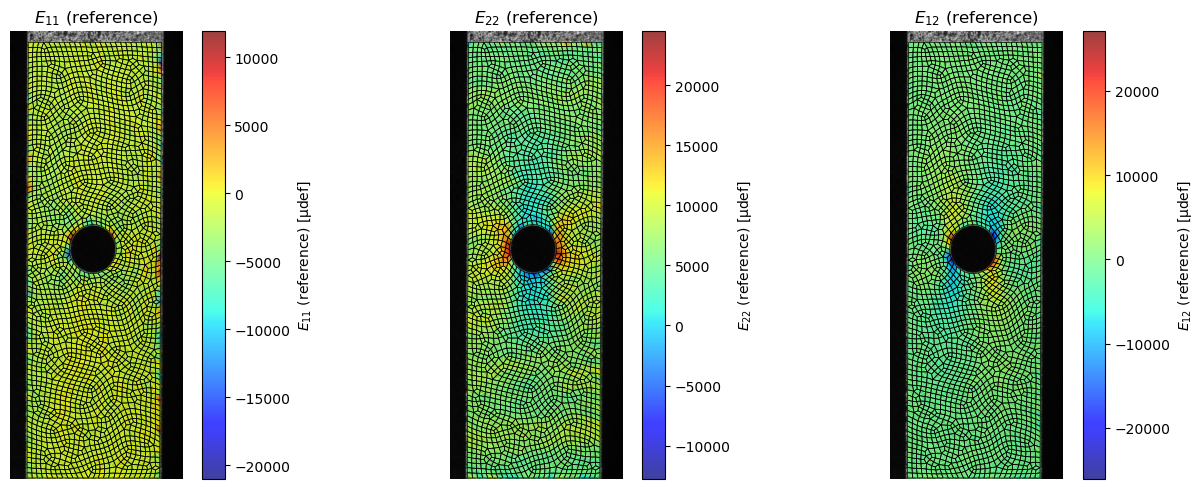

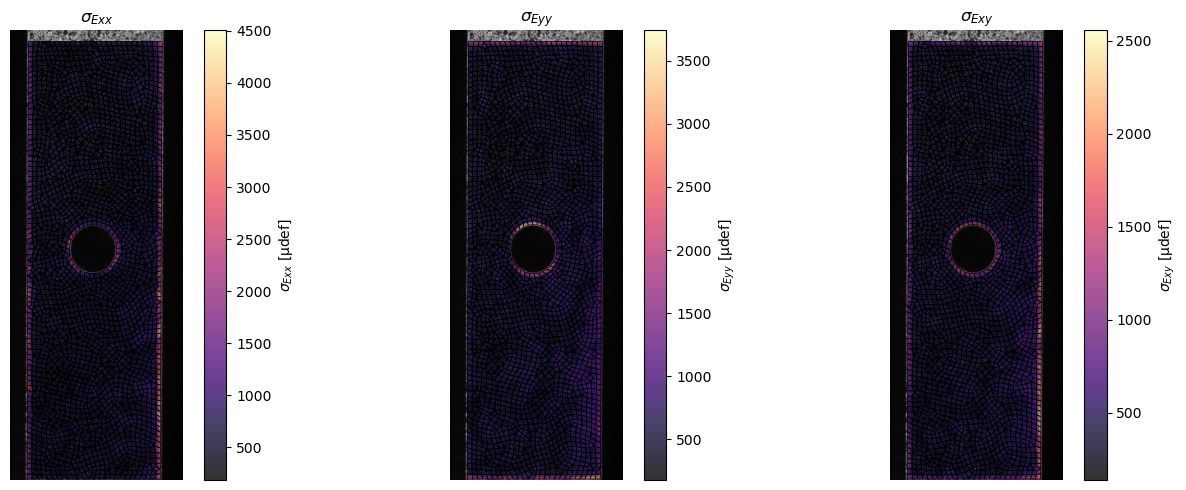

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ax, name in zip(axes, component_names):
    values = reference_strain_from_ad[name]
    title = plotter_ref._latex_label(name, "strain") + " (reference)"
    mesh = plot_scalar_field(ax, values, title)
    fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04, label=f"{title} [{strain_unit_label}]")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ax, name in zip(axes, component_names):
    values = std_strain_fields[name]
    title = rf"$\sigma_{{{name}}}$"
    mesh = plot_scalar_field(ax, values, title, cmap="magma", alpha=0.8)
    fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04, label=f"{title} [{strain_unit_label}]")
plt.tight_layout()
plt.show()


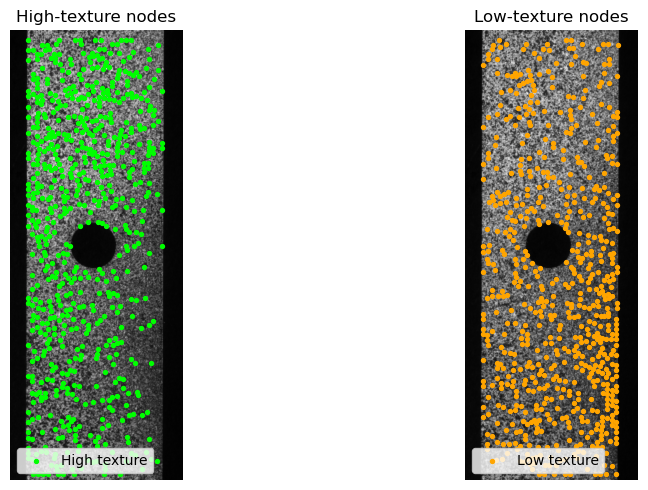

Exx: mean sigma high-texture = 5.317e-04, mean sigma low-texture = 6.744e-04
Eyy: mean sigma high-texture = 5.206e-04, mean sigma low-texture = 5.984e-04


In [34]:
# Texture-based masks (simple gradient magnitude on I1)
gradx_ref, grady_ref = central_differences(jnp.asarray(im_ref))
texture_map = np.sqrt(np.asarray(gradx_ref) ** 2 + np.asarray(grady_ref) ** 2)
node_coords = np.asarray(dic.node_coordinates_binned[:, :2])
H, W = texture_map.shape
jj = np.clip(np.round(node_coords[:, 0] - 0.5).astype(int), 0, W - 1)
ii = np.clip(np.round(node_coords[:, 1] - 0.5).astype(int), 0, H - 1)
texture_at_nodes = texture_map[ii, jj]

q25 = np.percentile(texture_at_nodes, 25)
q75 = np.percentile(texture_at_nodes, 75)
mask_low = texture_at_nodes <= q25
mask_high = texture_at_nodes >= q75

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
axes[0].imshow(im_ref, cmap="gray", origin="lower")
axes[0].scatter(node_coords[mask_high, 0], node_coords[mask_high, 1], s=8, c="lime", label="High texture")
axes[0].set_title("High-texture nodes")
axes[0].legend(loc="lower left")
axes[1].imshow(im_ref, cmap="gray", origin="lower")
axes[1].scatter(node_coords[mask_low, 0], node_coords[mask_low, 1], s=8, c="orange", label="Low texture")
axes[1].set_title("Low-texture nodes")
axes[1].legend(loc="lower left")
for ax in axes:
    ax.set_axis_off()
plt.tight_layout()
plt.show()

for name in component_names[:2]:
    high_std = std_strain_fields[name][mask_high]
    low_std = std_strain_fields[name][mask_low]
    print(
        f"{name}: mean sigma high-texture = {np.mean(high_std):.3e} {strain_unit_label}, "
        f"mean sigma low-texture = {np.mean(low_std):.3e} {strain_unit_label}"
    )


## 8. Sanity Check (Validation)
To validate the linearization we compare the JVP prediction against a finite-difference perturbation:
$$\frac{E(I_2 + h\,\delta I_2) - E(I_2)}{h}.$$
Agreement for small $h$ confirms that the JVP captures the correct directional derivative.

In [22]:
rng_key, val_key = random.split(rng_key)
delta_validation = sample_image_noise(val_key)
_, delta_E_lin = jax.jvp(end_to_end_strain, (im2_jax,), (delta_validation,))

h = 1e-3
finite_diff = (end_to_end_strain(im2_jax + h * delta_validation) - reference_strain_stack) / h

numerator = jnp.linalg.norm(delta_E_lin - finite_diff)
denom = jnp.linalg.norm(finite_diff)
rel_error = float(numerator / (denom + 1e-12))
max_abs = float(jnp.max(jnp.abs(delta_E_lin - finite_diff)))
print(f"Relative error ||JVP - FD|| / ||FD|| = {rel_error:.3e}")
print(f"Max absolute component-wise diff = {strain_scale * max_abs:.3e} {strain_unit_label}")


Relative error ||JVP - FD|| / ||FD|| = 1.959e-03
Max absolute component-wise diff = 5.431e-06


## 9. Discussion
- The uncertainty maps clearly highlight that textured regions (where speckle contrast is high) yield the smallest $\sigma_E$, while flat or shadowed areas near the ROI boundary suffer from amplified strain uncertainty.
- The first-order propagation is accurate for the chosen noise level, as evidenced by the finite-difference validation. For larger perturbations one should re-linearize or rely on second-order terms.
- The current model assumes independent pixel noise; extending it to correlated noise (e.g., optical blur), Gaussian process priors on images, or fully Bayesian DIC formulations would follow the same AD-based philosophy by injecting the corresponding covariance structure into the JVP sampling routine.
- Automatic differentiation thus serves a dual purpose: it powers the DIC solver itself and exposes gradients/JVPs that quantify uncertainty without explicitly forming or storing multi-million-entry Jacobians.